# Image Generation from ITdiffusion fine-tuning on CIFAR10 DDPM

We had previously sampled from the model (see  [sample_ITdiffusion_DDIM_cifar10_fine_tuned.ipynb](https://colab.research.google.com/drive/1cwAYqq1Jxhe0iGziStztxeEqqgndmaSQ?usp=sharing)) and saved the results in .npz files. In this notebook, we read these files and display the images

## Imports and setup and utils

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Setup and loading saved image arrays

In [2]:
import os

In [3]:
dir_gen_images = "drive/MyDrive/density_estimation/generated_images/generated_images_cifar10_ddpm/small/"
!ls $dir_gen_images

gen_cifar10_fine_tuned.npz  gen_cifar10_original.npz


In [4]:
path_gen_images_fine_tuned = os.path.join(dir_gen_images, "gen_cifar10_fine_tuned.npz")
!stat $path_gen_images_fine_tuned

  File: drive/MyDrive/density_estimation/generated_images/generated_images_cifar10_ddpm/small/gen_cifar10_fine_tuned.npz
  Size: 196872    	Blocks: 385        IO Block: 65536  regular file
Device: 29h/41d	Inode: 508         Links: 1
Access: (0600/-rw-------)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2023-04-27 23:13:06.000000000 +0000
Modify: 2023-04-27 23:11:39.000000000 +0000
Change: 2023-04-27 23:13:06.000000000 +0000
 Birth: -


In [5]:
path_gen_images_original = os.path.join(dir_gen_images, "gen_cifar10_original.npz")
!stat $path_gen_images_original

  File: drive/MyDrive/density_estimation/generated_images/generated_images_cifar10_ddpm/small/gen_cifar10_original.npz
  Size: 196872    	Blocks: 385        IO Block: 65536  regular file
Device: 29h/41d	Inode: 509         Links: 1
Access: (0600/-rw-------)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2023-04-27 23:13:06.000000000 +0000
Modify: 2023-04-27 23:11:46.000000000 +0000
Change: 2023-04-27 23:13:06.000000000 +0000
 Birth: -


In [6]:
def display_images_grid(images, grid_shape):
    n, _, w, h = images.shape
    n_rows = w * grid_shape[0]
    n_cols = h * grid_shape[1]

    assert n >= grid_shape[0] * grid_shape[1], "you have fewer images than grid spaces!"

    new_im = PIL.Image.new('RGB', (n_rows, n_cols))

    idx = 0
    for i in range(0, n_rows, w):
        for j in range(0, n_cols, h):
            image_processed = np.transpose(images[idx:idx+1], (0, 2, 3, 1))
            image_processed = (image_processed + 1.0) * 127.5
            image_processed = image_processed.astype(np.uint8)
            im=PIL.Image.fromarray(image_processed[0])
            #paste the image at location i,j:
            new_im.paste(im, (i,j))
            idx += 1

    new_im.show()

In [7]:
import PIL.Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


def display_sample(sample, idx=0, custom_figsize=None):
    # image_processed = sample.permute(0, 2, 3, 1).astype(np.uint8)
    image_processed = np.transpose(sample, (0, 2, 3, 1))
    image_processed = (image_processed + 1.0) * 127.5
    # print(image_processed.shape)
    image_processed = image_processed.astype(np.uint8)
    image_pil = PIL.Image.fromarray(image_processed[idx])

    if custom_figsize:
        plt.figure(figsize=custom_figsize)
        plt.imshow(image_pil)

    else:
        display(image_pil)    


def display_sample_single(sample, custom_figsize=None):
    image_processed = np.transpose(sample, (1, 2, 0))
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.astype(np.uint8)
    image_pil = PIL.Image.fromarray(image_processed)

    if custom_figsize:
        plt.figure(figsize=custom_figsize)
        plt.imshow(image_pil)

    else:
        display(image_pil) 

## Section 1: Images generated from Huggingface's pre-trained CIFAR10 DDPM

In [8]:
sample_original = np.load(path_gen_images_original)["arr_0"]
sample_original.shape

(16, 3, 32, 32)

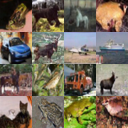

In [9]:
display_images_grid(sample_original, (4, 4))

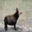

In [10]:
display_sample(sample_original, idx=14)

## Try to evaluate likelihoods

In [11]:
import time
import numpy as np
import math
import tqdm
from tqdm import trange
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.8/934.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.0 MB/s eta 0:00:00


In [13]:
import torch
from diffusers import UNet2DModel

In [14]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 5.9 MB/s eta 0:00:00


In [15]:
# Huggingface hub directory from which we get the pre-trained CIFAR10 DDPM model's config 
model_id = "google/ddpm-cifar10-32"

In [16]:
model = UNet2DModel.from_pretrained(model_id)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [17]:
from diffusers import DDPMScheduler, DDIMScheduler

scheduler = DDPMScheduler.from_config(model_id)
# scheduler = DDIMScheduler.from_config(model_id)

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [18]:
import torch.nn.functional as F

In [19]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_large'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.1.1')])

In [20]:
# timesteps = torch.LongTensor(np.arange(1, num_train_timesteps, 12))
# n_timesteps_loss_calc = len(timesteps)

def get_vlb_log_likelihood(model, scheduler, x_start, timesteps):
    n_timesteps_loss_calc = len(timesteps)
    # noise = torch.randn(x_start.shape)
    noise = torch.randn(
        n_timesteps_loss_calc, model.config.in_channels, model.config.sample_size, model.config.sample_size
    )

    noised_image = scheduler.add_noise(x_start, noise, timesteps)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = model(noised_image, timesteps).sample

    print(noise_pred.shape)
    print(noise.shape)
    loss = F.mse_loss(noise_pred, noise).detach()
    print( -loss)

In [21]:
num_train_timesteps = scheduler.config.num_train_timesteps
print(num_train_timesteps)

1000


In [70]:
timesteps = torch.randint(0, num_train_timesteps, (200,)).long()
# timesteps = torch.LongTensor(np.arange(1, num_train_timesteps, 1))

### Calculate log likelihood on sample from DDPM

In [71]:
test_idx = 14
test_img = sample_original[test_idx]
x_start = torch.tensor([test_img]) #.permute(0, 2, 3, 1)
print(x_start.shape)

torch.Size([1, 3, 32, 32])


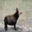

In [72]:
# display_sample(sample_fine_tuned, idx=test_idx)
display_sample_single(test_img)

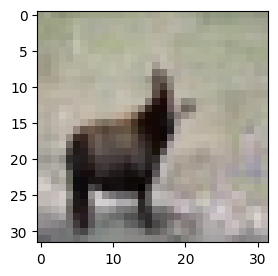

In [73]:
image_processed = x_start.cpu().permute(0, 2, 3, 1)
image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.numpy().astype(np.uint8)

image_pil = PIL.Image.fromarray(image_processed[0])
plt.figure(figsize=(3,3))   
plt.imshow(image_pil)

In [74]:
%%time
# timesteps = torch.randint(0, num_train_timesteps, (100,)).long()
# timesteps = torch.LongTensor(np.arange(1, num_train_timesteps, 1))
# print("timesteps: ", timesteps)
get_vlb_log_likelihood(model, scheduler, x_start, timesteps)

torch.Size([200, 3, 32, 32])
torch.Size([200, 3, 32, 32])
tensor(-0.0237)
CPU times: user 41.1 s, sys: 8.48 s, total: 49.6 s
Wall time: 50.2 s


### Calculate log likelihood on sample from DDPM, but rotated

In [75]:
x_start_rotated = x_start.permute(0, 1, 3, 2)
print(x_start_rotated.shape)

torch.Size([1, 3, 32, 32])


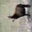

In [76]:
display_sample_single(torch.squeeze(x_start_rotated).cpu().numpy())

In [77]:
# plt.figure(figsize=(3,3))
# plt.imshow(torch.squeeze(x_start_rotated).permute(1,2,0).cpu().numpy())

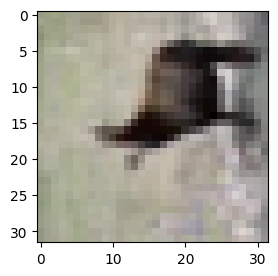

In [78]:
image_processed = x_start_rotated.cpu().permute(0, 2, 3, 1)
image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.numpy().astype(np.uint8)

image_pil = PIL.Image.fromarray(image_processed[0])
plt.figure(figsize=(3,3))   
plt.imshow(image_pil)

In [79]:
%%time
# timesteps = torch.randint(0, num_train_timesteps, (100,)).long()
# timesteps = torch.LongTensor(np.arange(1, num_train_timesteps, 1))
# print("timesteps: ", timesteps)
get_vlb_log_likelihood(model, scheduler, x_start_rotated, timesteps)

torch.Size([200, 3, 32, 32])
torch.Size([200, 3, 32, 32])
tensor(-0.0267)
CPU times: user 43 s, sys: 8.93 s, total: 52 s
Wall time: 53.3 s


### Calculate log likelihood on sample from DDPM, but rotated and with erasures

In [80]:
import copy

In [81]:
x_start_rotated_erasures = copy.deepcopy(x_start_rotated)

In [82]:
# x_start_rotated[:, :, 10, :] = torch.zeros((1, 3, 32))

In [83]:
# x_start_rotated[:, :, 10, :]

In [84]:
x_start_rotated_erasures[:, :, 10:20, :].shape

torch.Size([1, 3, 10, 32])

In [85]:
# x_start_rotated[:, :, 10:20, :] = torch.zeros((1, 3, 10, 32))
x_start_rotated_erasures[:, :, 10: 20, :] = torch.full((1, 3, 10, 32), -1.0)

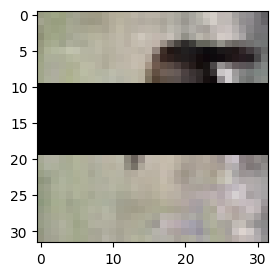

In [86]:
image_processed = x_start_rotated_erasures.cpu().permute(0, 2, 3, 1)
image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.numpy().astype(np.uint8)

image_pil = PIL.Image.fromarray(image_processed[0])
plt.figure(figsize=(3,3))   
plt.imshow(image_pil)

In [87]:
%%time
# timesteps = torch.randint(0, num_train_timesteps, (100,)).long()
# timesteps = torch.LongTensor(np.arange(1, num_train_timesteps, 1))
# print("timesteps: ", timesteps)
get_vlb_log_likelihood(model, scheduler, x_start_rotated_erasures, timesteps)

torch.Size([200, 3, 32, 32])
torch.Size([200, 3, 32, 32])
tensor(-0.0231)
CPU times: user 40.9 s, sys: 8.37 s, total: 49.2 s
Wall time: 49.2 s


### Calculate log likelihood on sample from DDPM, but rotated and with even more erasures

In [88]:
x_start_rotated_erasures_extreme = copy.deepcopy(x_start_rotated)

In [89]:
x_start_rotated_erasures_extreme[:, :, 5: 27, :].shape

torch.Size([1, 3, 22, 32])

In [90]:
x_start_rotated_erasures_extreme[:, :, 5: 27, :] = torch.full((1, 3, 22, 32), -1.0)

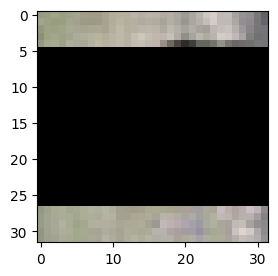

In [91]:
image_processed = x_start_rotated_erasures_extreme.cpu().permute(0, 2, 3, 1)
image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.numpy().astype(np.uint8)

image_pil = PIL.Image.fromarray(image_processed[0])
plt.figure(figsize=(3,3))   
plt.imshow(image_pil)

In [92]:
%%time
# timesteps = torch.randint(0, num_train_timesteps, (100,)).long()
# timesteps = torch.LongTensor(np.arange(1, num_train_timesteps, 1))
# print("timesteps: ", timesteps)
get_vlb_log_likelihood(model, scheduler, x_start_rotated_erasures_extreme, timesteps)

torch.Size([200, 3, 32, 32])
torch.Size([200, 3, 32, 32])
tensor(-0.0131)
CPU times: user 41.4 s, sys: 8.93 s, total: 50.4 s
Wall time: 50.7 s


### Calculate log likelihood on zero image

In [93]:
x_start_zero = torch.full(x_start.shape, -1.0)
print(x_start_zero.shape)

torch.Size([1, 3, 32, 32])


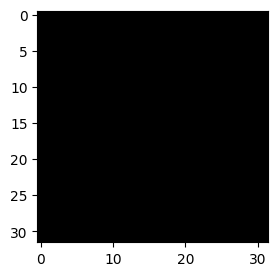

In [94]:
image_processed = x_start_zero.cpu().permute(0, 2, 3, 1)
image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.numpy().astype(np.uint8)

image_pil = PIL.Image.fromarray(image_processed[0])
plt.figure(figsize=(3,3))   
plt.imshow(image_pil)

In [95]:
%%time
# timesteps = torch.randint(0, num_train_timesteps, (100,)).long()
# timesteps = torch.LongTensor(np.arange(1, num_train_timesteps, 1))
# print("timesteps: ", timesteps)
get_vlb_log_likelihood(model, scheduler, x_start_zero, timesteps)

torch.Size([200, 3, 32, 32])
torch.Size([200, 3, 32, 32])
tensor(-0.0012)
CPU times: user 39.4 s, sys: 8.62 s, total: 48 s
Wall time: 48.1 s


### Calculate log likelihood on sample from MNIST (out of distribution)

In [96]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = load_data('drive/MyDrive/density_estimation/data/mnist/mnist.npz')

In [97]:
test_img_mnist = mnist_x_test[0]
x_start_mnist = torch.tensor(test_img_mnist)
x_start_mnist = torch.unsqueeze(x_start_mnist, 0)
x_start_mnist = torch.unsqueeze(x_start_mnist, 0)
print(x_start_mnist.shape)

torch.Size([1, 1, 28, 28])


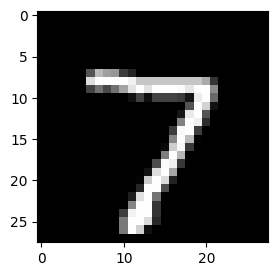

In [98]:
plt.figure(figsize=(3,3))
plt.imshow(test_img_mnist, cmap='gray')

In [99]:
# x_start_mnist_padded = F.pad(input=x_start_mnist, pad=(0, 4, 0, 0), mode='constant', value=0.)
# print(x_start_mnist_padded.shape)
x_start_mnist_padded = torch.zeros(x_start.shape)
x_start_mnist_padded[:, :1, :28, :28] = x_start_mnist

print(x_start_mnist_padded.shape)

torch.Size([1, 3, 32, 32])


In [100]:
test_img_mnist_padded = torch.squeeze(x_start_mnist_padded).permute(1, 2, 0).cpu().numpy()
print(test_img_mnist_padded.shape)

(32, 32, 3)


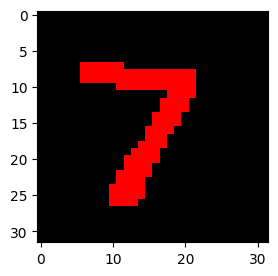

In [101]:
plt.figure(figsize=(3,3))
plt.imshow(test_img_mnist_padded)

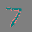

In [102]:
display_sample_single(np.transpose(test_img_mnist_padded, (2, 0, 1)))

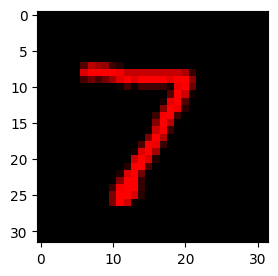

In [103]:
image_processed = x_start_mnist_padded.permute(0, 2, 3, 1)
# image_processed = (image_processed + 1.0) * 127.5
image_processed = image_processed.numpy().astype(np.uint8)

image_pil = PIL.Image.fromarray(image_processed[0])
plt.figure(figsize=(3,3))   
plt.imshow(image_pil)

In [104]:
%%time
# timesteps = torch.randint(0, num_train_timesteps, (100,)).long()
# timesteps = torch.LongTensor(np.arange(1, num_train_timesteps, 1))
get_vlb_log_likelihood(model, scheduler, x_start_mnist_padded, timesteps)

torch.Size([200, 3, 32, 32])
torch.Size([200, 3, 32, 32])
tensor(-2.7556)
CPU times: user 42.1 s, sys: 8.48 s, total: 50.6 s
Wall time: 50.7 s


### Calculate log likelihood on sample that is just random noise (out of distribution)

In [105]:
x_start_random = torch.rand(x_start.shape) * 256
x_start_random.shape

torch.Size([1, 3, 32, 32])

In [106]:
%%time
# timesteps = torch.randint(0, num_train_timesteps, (100,)).long()
# timesteps = torch.LongTensor(np.arange(1, num_train_timesteps, 1))
get_vlb_log_likelihood(model, scheduler, x_start_random, timesteps)

torch.Size([200, 3, 32, 32])
torch.Size([200, 3, 32, 32])
tensor(-3.8368)
CPU times: user 42.3 s, sys: 8.87 s, total: 51.1 s
Wall time: 51.2 s


## Section 2: Images generated from original pre-trained CIFAR10 DDPM

In [107]:
sample_original = np.load(path_gen_images_original)["arr_0"]
sample_original.shape

(16, 3, 32, 32)

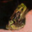

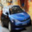

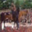

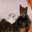

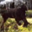

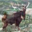

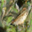

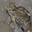

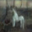

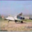

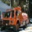

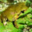

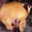

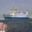

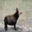

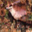

In [108]:
for idx in range(0, sample_original.shape[0]):
    display_sample(sample_original, idx=idx)

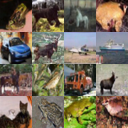

In [109]:
display_images_grid(sample_original, (4, 4))

In [110]:
# for idx in range(0, sample_original.shape[0]):
#     display_sample(sample_original, idx=idx, custom_figsize=(5,5))